# PyTorch Tutorial - AE and VAE

Jinhyeok Jeong 
2024-08-20

So far, we've focused on convolutional neural networks (CNN) for image classification.

This time, we will learn somewhat different architecture of neural networks: 

```AE (Autoencoder)```, and ```VAE (Variational Autoencoder)```


These network architectures are commonly used for unsupervised learning.

Load packages

In [1]:
import torch
from torch import nn 

import torchvision
from torchvision import datasets 
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np 
import matplotlib.pyplot as plt 

from torchinfo import summary

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda:0') 
    print('GPU')
elif torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current Pytorch install was not build with MPS enabled.")
        device=torch.device('cpu')
    device = torch.device('mps') # for MacOS devices with MPS support.
else:
    device = torch.device('cpu')
    print('CPU')

GPU


## Prepare an imageset (MNIST)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 7137766.27it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1000823.67it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8245110.38it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2270082.07it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

torch.Size([64, 1, 28, 28])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])


Text(0.5, 1.0, 'Example of training images')

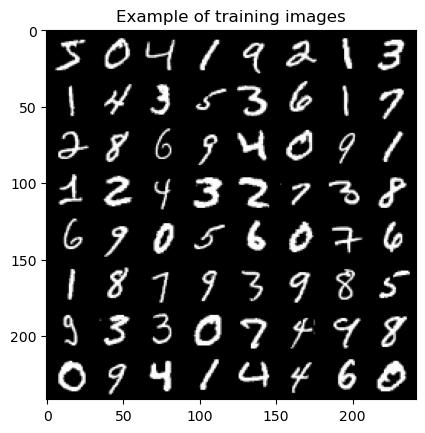

In [3]:
import torchvision
from torchvision import datasets 
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())

# loaded dataset can be passed to DataLoader, which performs several operations including batching, sampling, and shuffling.
batch_size = 64 

train_loader = DataLoader(training_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# check the training batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
 
print(images.shape) # shape: (sample, color_channel, image height, image width)
print(labels) # labels are not one-hot encoded. 

# visualization
# utils.make_grid concatenate images as a grid, and np.transpose change the order of dimensions (channel,h,w) -> (h,w,channel)
plt.imshow(np.transpose(torchvision.utils.make_grid(images),(1,2,0)))
plt.title('Example of training images')

## Autoencoder (AE)

Autoencoder is an unsupervised neural network model that is often used for dimensionality reduction. 
By imposing a bottleneck (smaller number of units in the hidden layer) between encoder and decoder, it learns the representations that can reconstruct the original inputs with a fewer number of units. 

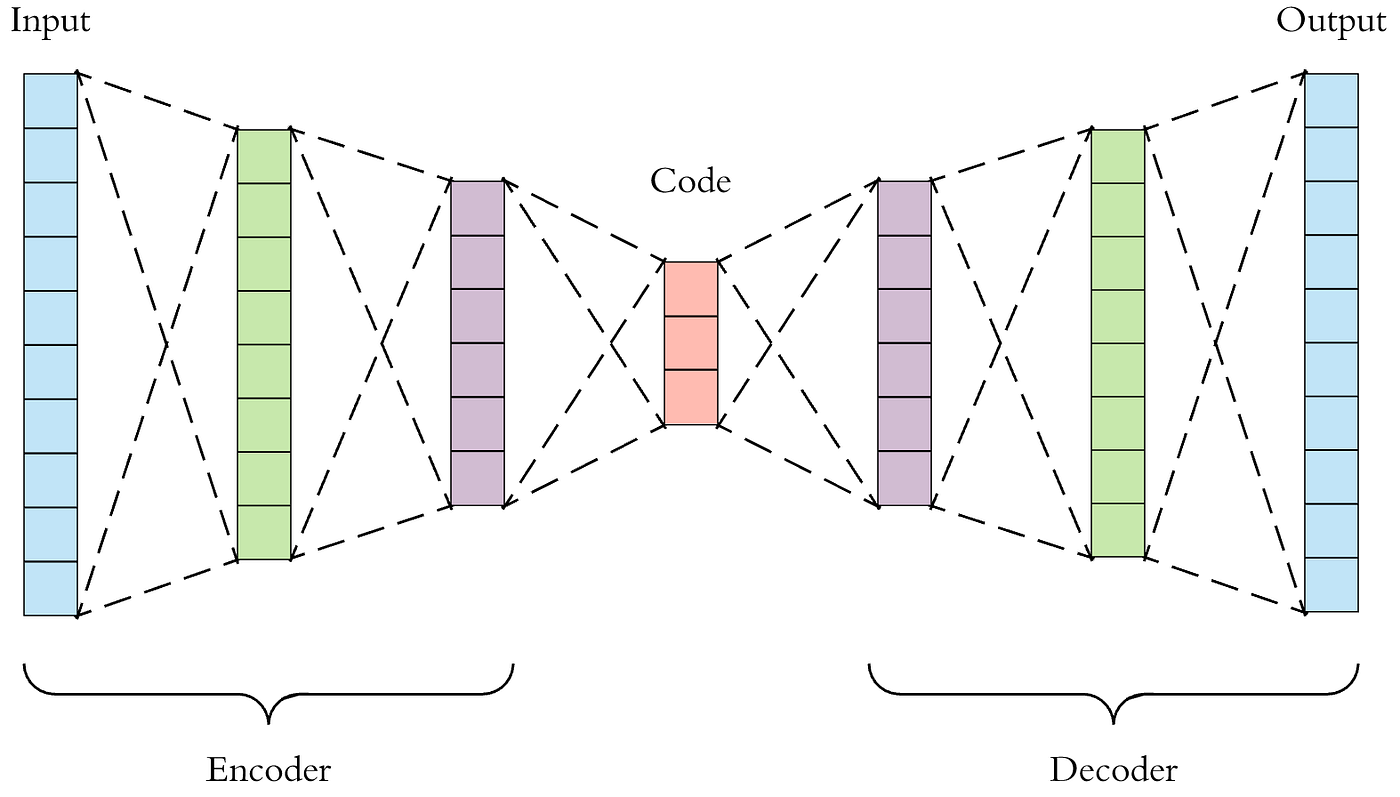

Autoencoder is simple and straightforward in terms of its architecture and loss function. 

Although it doesn't have to be, the number of layers and dimensions for each layer tend to be symmetric between encoder and decoder. </br>
The current example uses a dense (linear) layer, but you can also use other layers like convolutional layers.

The autoencoder is similar to the PCA in that it does dimensionality reduction. If you use a linear activation function, your autoencoder could be *nearly* equivalent to PCA. 

In [13]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2)
        ) 
        self.decoder = nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28*28),            
        )      

    def encode(self, x):
        return self.encoder(x)
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)

        # z = self.encoder(x)
        # x_hat = self.decoder(z)
        return x_hat

model_ae = AE()
# summary(model_ae)
print(model_ae)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
  )
)


In [58]:
# define model instance
model_ae = AE().to(device)

# define loss function & set optimizer
mse_loss_func = torch.nn.MSELoss() # Autoencoder use the differences between input and output as a loss function. 
optim = torch.optim.Adam(model_ae.parameters(), 
                         lr = 3e-4)

n_epoch = 100

train_loss_epochs = []

for epoch in range(n_epoch):

    # running loss
    train_loss = 0.0

    # training
    model_ae.train() 

    for i, data in enumerate(train_loader, 0):

        # get the inputs
        images, _ = data 
        images = images.reshape((-1, 28*28)).to(device)

        # zero the parameter gradients 
        optim.zero_grad() 

        # input the images & calculate the loss
        outputs = model_ae(images)
        loss = mse_loss_func(outputs, images)

        # update weights based on the gradient
        loss.backward() # back-propagation
        optim.step() # update the weights based on the gradient

        train_loss += loss.item()#*images.size(0)  

    print(f"epoch: {epoch+1}/{n_epoch}, train loss: {train_loss/len(training_data):.4f}")
    train_loss_epochs.append(train_loss/len(training_data))

epoch: 1/100, train loss: 0.0009
epoch: 2/100, train loss: 0.0007
epoch: 3/100, train loss: 0.0007
epoch: 4/100, train loss: 0.0007
epoch: 5/100, train loss: 0.0007
epoch: 6/100, train loss: 0.0006
epoch: 7/100, train loss: 0.0006
epoch: 8/100, train loss: 0.0006
epoch: 9/100, train loss: 0.0006
epoch: 10/100, train loss: 0.0006
epoch: 11/100, train loss: 0.0006
epoch: 12/100, train loss: 0.0006
epoch: 13/100, train loss: 0.0006
epoch: 14/100, train loss: 0.0006
epoch: 15/100, train loss: 0.0006
epoch: 16/100, train loss: 0.0006
epoch: 17/100, train loss: 0.0006
epoch: 18/100, train loss: 0.0006
epoch: 19/100, train loss: 0.0006
epoch: 20/100, train loss: 0.0006
epoch: 21/100, train loss: 0.0006
epoch: 22/100, train loss: 0.0006
epoch: 23/100, train loss: 0.0006
epoch: 24/100, train loss: 0.0006
epoch: 25/100, train loss: 0.0006
epoch: 26/100, train loss: 0.0006
epoch: 27/100, train loss: 0.0006
epoch: 28/100, train loss: 0.0006
epoch: 29/100, train loss: 0.0006
epoch: 30/100, train lo

In [59]:
# save the trained model
torch.save(model_ae.state_dict(), 'AE_weights.pth')

# # load the trained model
# model_ae.load_state_dict(torch.load('AE_weights.pth'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed images from Autoencoder')

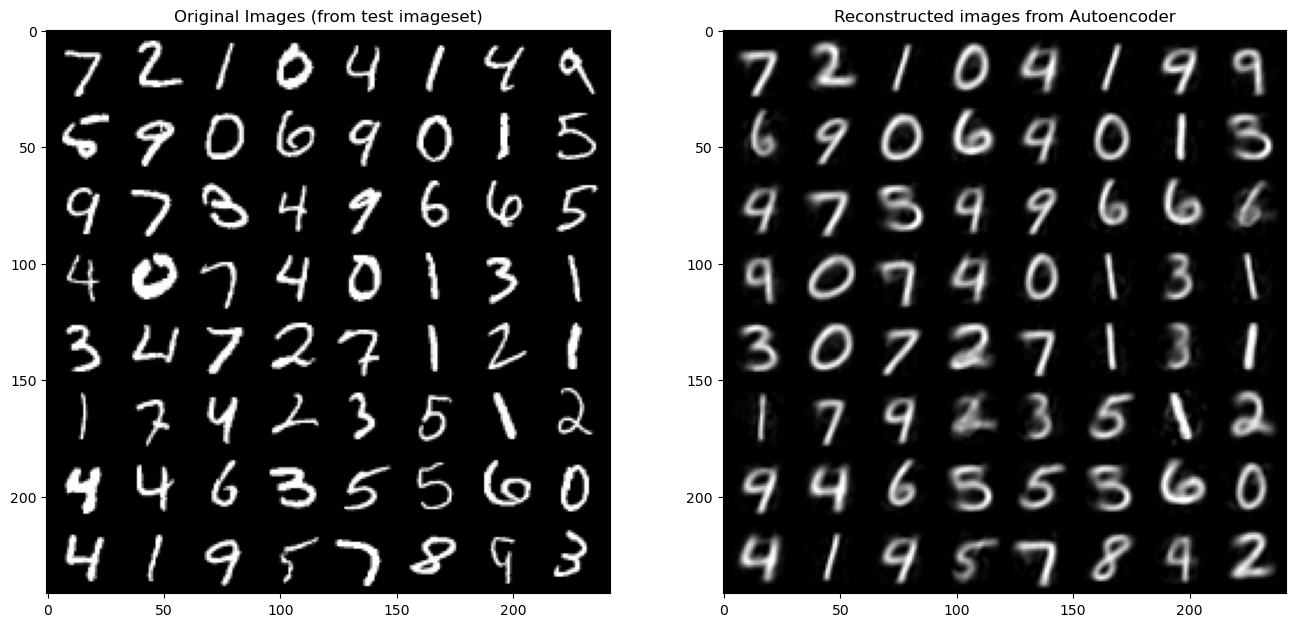

In [60]:
# testing performance of AE
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model_ae(images.reshape((-1,28*28)).to(device))

fig, axs = plt.subplots(1,2,figsize=(16,8))

axs[0].imshow(np.transpose(torchvision.utils.make_grid(images),(1,2,0)))
axs[1].imshow(np.transpose(torchvision.utils.make_grid(outputs.cpu().detach().reshape(images.shape)),(1,2,0)))
axs[0].set_title('Original Images (from test imageset)')
axs[1].set_title('Reconstructed images from Autoencoder')

## Variational Autoencoder (VAE)

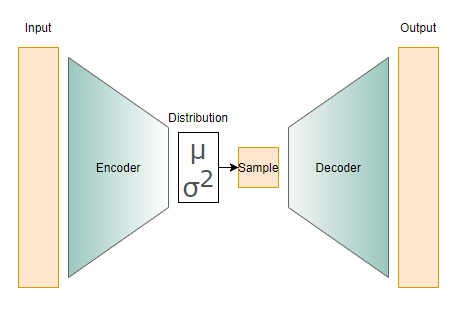

VAE is an extension of AE, and you may want to use this more frequently than AE if you are interested in working with latent representations learned by neural network models.

To achieve more meaningful and structured latent representations, VAE assumes that there is the underlying distribution of latent variables that make observed data. It is assumed to be a Gaussian distribution without covariance across the dimensions.

Mathematically, the goal of VAE is to model $p_{\theta}(x)=\int p_{\theta}(z)p_{\theta}(x|z) dz$ , where x is data and z is the underlying latent variable, and $x_{i} \sim p_{\theta}(x|z)$.

Because this is intractable problem, variational inferences are used to optimize the model (see the original VAE paper for in detail: https://arxiv.org/abs/1312.6114).


Based on the variational inferences, we can derive the ELBO (Evidence lower bound), which is a lower bound of log-likelihood, and then use it for defining a loss function.

$\log p(x) \ge \log{p(x|z)}-\text{KL}[q(z|x) \| p(x) ]$

$\mathcal{L} = -\log p(x) = -\log p(x|z) + \text{KL}[q(z|x) \| p(x)]$


The first term is MSE loss, and the second term is a regularizer term. 
Under the assumptions that a prior distribution p(x) is the standard normal distribution and that the variational distribution of posterior q(z|x) is Gaussian without covaraince, the second term can be simplified.

$$
\text{KL}[q\| p] = 0.5 (\log \frac{\det\Sigma_p}{\det\Sigma_q} - k + \text{tr}\Sigma_p^{-1}\Sigma_q + (\mu_2 - \mu_1)^T\Sigma_p^{-1} (\mu_2 - \mu_1))
$$

$$
\text{KL}[q\| \mathcal{N}(0,I) ] = 0.5 (-\text{tr}\log \Sigma_q - k + \text{tr}\Sigma_q + \mu_q^T \mu_q)
$$



In [52]:
class VAE(nn.Module):
    def __init__(self, n_z=2):
        super().__init__()

        self.n_z = n_z

        self.encoder = nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2*n_z) # we need to double this for encoding mean & var. The output of encoder in VAE is the mean and variance for variational inference
        ) 
        self.decoder = nn.Sequential(
            torch.nn.Linear(n_z, 64), # the input of decoder in VAE would be sampled value from latent distribution (which is assumed to be Gaussian)
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28*28),            
        )      

    def encode_to_mean_lss(self,x):
        encoded = self.encoder(x)
        mean = encoded[...,:self.n_z]
        log_sigma_sq = encoded[...,self.n_z:]

        return mean, log_sigma_sq

    def encode_mean(self,x):
        # this function is not necessary during training, but may be useful if you want to extract the latent representations after training
        mean, _ =self.encode_to_mean_lss(x)
        return mean

    def encode(self,x):
        # this function is not necessary during training, but may be useful if you want to extract the latent representations after training
        mean, log_sigma_sq = self.encode_to_mean_lss(x)
        sigma = log_sigma_sq.exp().sqrt()
        return mean + torch.randn_like(mean)*sigma
    
    def decode(self,z):
        # this function is not necessary during training, but may be useful if you want to generate a new example after training.
        return self.decoder(z)

    def forward(self,x):
        mean, log_sigma_sq = self.encode_to_mean_lss(x)
        sigma = log_sigma_sq.exp().sqrt()
        z = mean + torch.randn_like(mean)*sigma 
        output = self.decoder(z)

        return output, mean, log_sigma_sq    

model_vae = VAE(n_z=2)
# summary(model_ae)
print(model_vae)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
  )
)


In [53]:
# this is an implementation of the second term of VAE loss
def KL_div_N01(z_mu, z_log_sigma_sq):
    term_1 = z_log_sigma_sq.sum(axis=1) # this is trace log Sigma q
    term_2 = z_log_sigma_sq.exp().sum(axis=1) # this is trace Sigma q
    term_3 = (z_mu*z_mu).sum(axis=1) # this is mu_q squared and summed
    return 0.5*(-term_1 + term_2 + term_3 - z_mu.shape[1]).mean() #k is a constant, so we're going to ignore that

One difficulty of training VAE is that its loss function consists of two different terms. Performance of VAE depends on whether these two terms (MSE loss, KL-div loss) are balanced well. For this reason, weights can be assigned to these terms to improve the performance of VAE ($\beta$-VAE: https://arxiv.org/abs/1804.03599). It has been shown that $\beta$-VAE has more interpretable latent dimensions. 

Although weights are not assigned in this example, I changed the way of defining MSE loss function (changed the argument) to avoid potential issues. If you remove the reduction argument, you may see poor reconstruction results after training. Specifically, you may see blob-like patterns regardless of input images. 

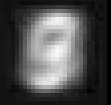

This phenomenon is called posterior collapse, and it is often caused by too high contribution of KL loss (or too low contribution of MSE loss) during training. 


In [54]:
# define model instance
model_vae = VAE(n_z=2).to(device)

# define loss function & set optimizer
# default value of an argument 'reduction' is mean, but here I used sum. 
# this only changes the scale of MSE loss function values and would not change the result in many cases, but it can be matter when training VAE.
# Since the loss function of VAE consists of two terms (MSE loss and KL div loss), they need to be properly balanced for optimal performance. 
# If the contribution of MSE loss is too low, the output will not look like images but look like prior distribution (standard normal distribution), which is called "posterior collapsing"
# there are many ways to address this issue, and I increased the value of MSE loss in general to avoid this problem.
mse_loss_func = torch.nn.MSELoss(reduction='sum')  
kl_loss_func = KL_div_N01

optim = torch.optim.Adam(model_vae.parameters(), 
                         lr = 3e-4)

n_epoch = 100

train_loss_epochs = []

for epoch in range(n_epoch):

    # running loss
    train_mse_loss = 0.0
    train_kl_loss = 0.0
    train_loss = 0.0

    # training
    model_vae.train() 

    for i, data in enumerate(train_loader, 0):

        # get the inputs
        images, _ = data 
        images = images.reshape((-1, 28*28)).to(device)

        # zero the parameter gradients 
        optim.zero_grad() 

        # input the images & calculate the loss
        outputs, mean, log_sigma_sq = model_vae.forward(images)

        mse_loss = mse_loss_func(outputs, images)
        kl_loss = kl_loss_func(mean, log_sigma_sq)
        loss = mse_loss + kl_loss

        # update weights based on the gradient
        loss.backward() # back-propagation
        optim.step() # update the weights based on the gradient

        train_mse_loss += mse_loss.item()#*images.size(0)  
        train_kl_loss += kl_loss.item()#*images.size(0)  
        train_loss += loss.item()#*images.size(0)  

    print(f"epoch: {epoch+1}/{n_epoch}, total loss: {train_loss/len(training_data):.4f}, MSE loss:{train_mse_loss/len(training_data):.4f}, KL loss: {train_kl_loss/len(training_data):.4f}")
    train_loss_epochs.append(train_loss/len(training_data))

epoch: 1/100, total loss: 45.8427, MSE loss:45.7182, KL loss: 0.1245
epoch: 2/100, total loss: 37.9369, MSE loss:37.7523, KL loss: 0.1846
epoch: 3/100, total loss: 35.3933, MSE loss:35.2063, KL loss: 0.1870
epoch: 4/100, total loss: 33.9565, MSE loss:33.7702, KL loss: 0.1863
epoch: 5/100, total loss: 33.0456, MSE loss:32.8615, KL loss: 0.1842
epoch: 6/100, total loss: 32.3766, MSE loss:32.1949, KL loss: 0.1817
epoch: 7/100, total loss: 31.8621, MSE loss:31.6849, KL loss: 0.1772
epoch: 8/100, total loss: 31.4685, MSE loss:31.2922, KL loss: 0.1763
epoch: 9/100, total loss: 31.1612, MSE loss:30.9876, KL loss: 0.1736
epoch: 10/100, total loss: 30.8505, MSE loss:30.6787, KL loss: 0.1719
epoch: 11/100, total loss: 30.5699, MSE loss:30.3988, KL loss: 0.1711
epoch: 12/100, total loss: 30.3195, MSE loss:30.1484, KL loss: 0.1711
epoch: 13/100, total loss: 30.1018, MSE loss:29.9327, KL loss: 0.1692
epoch: 14/100, total loss: 29.8731, MSE loss:29.7042, KL loss: 0.1689
epoch: 15/100, total loss: 29

In [55]:
# save the trained model
torch.save(model_vae.state_dict(), 'VAE_weights.pth')

# # load the trained model
# model_ae.load_state_dict(torch.load('AE_weights.pth'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed images from Variational Autoencoder')

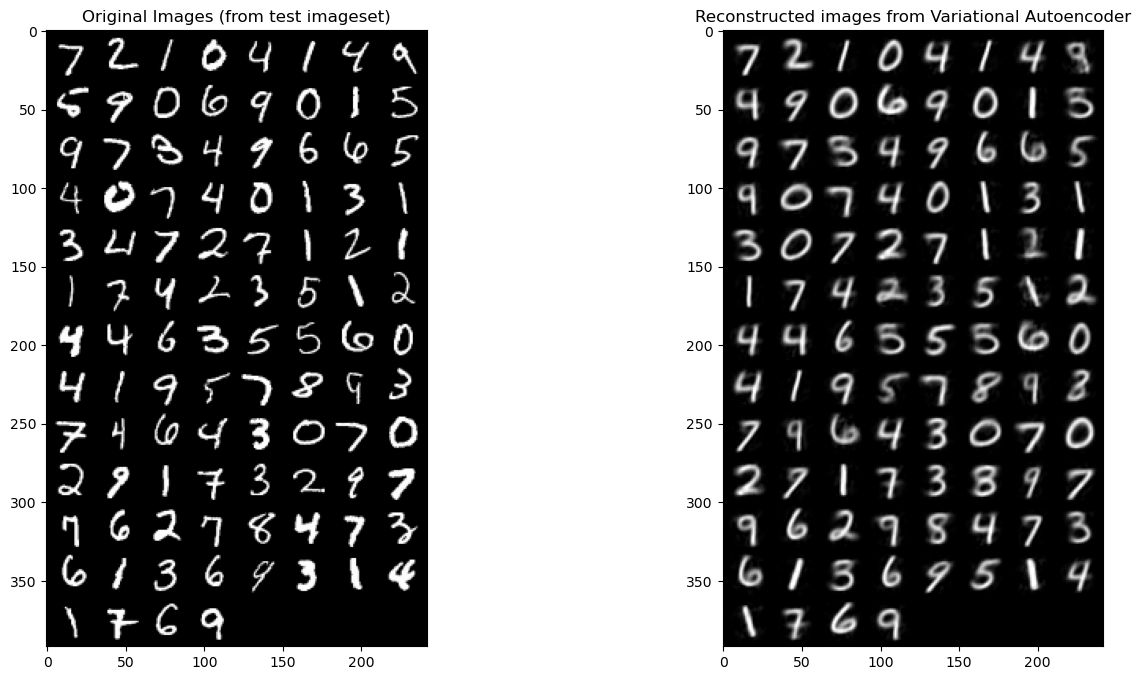

In [150]:
# testing performance of VAE
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs, _, _ = model_vae(images.reshape((-1,28*28)).to(device))

fig, axs = plt.subplots(1,2,figsize=(16,8))

axs[0].imshow(np.transpose(torchvision.utils.make_grid(images),(1,2,0)))
axs[1].imshow(np.transpose(torchvision.utils.make_grid(outputs.cpu().detach().reshape(images.shape)),(1,2,0)))
axs[0].set_title('Original Images (from test imageset)')
axs[1].set_title('Reconstructed images from Variational Autoencoder')

## Comparison of AE and VAE

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


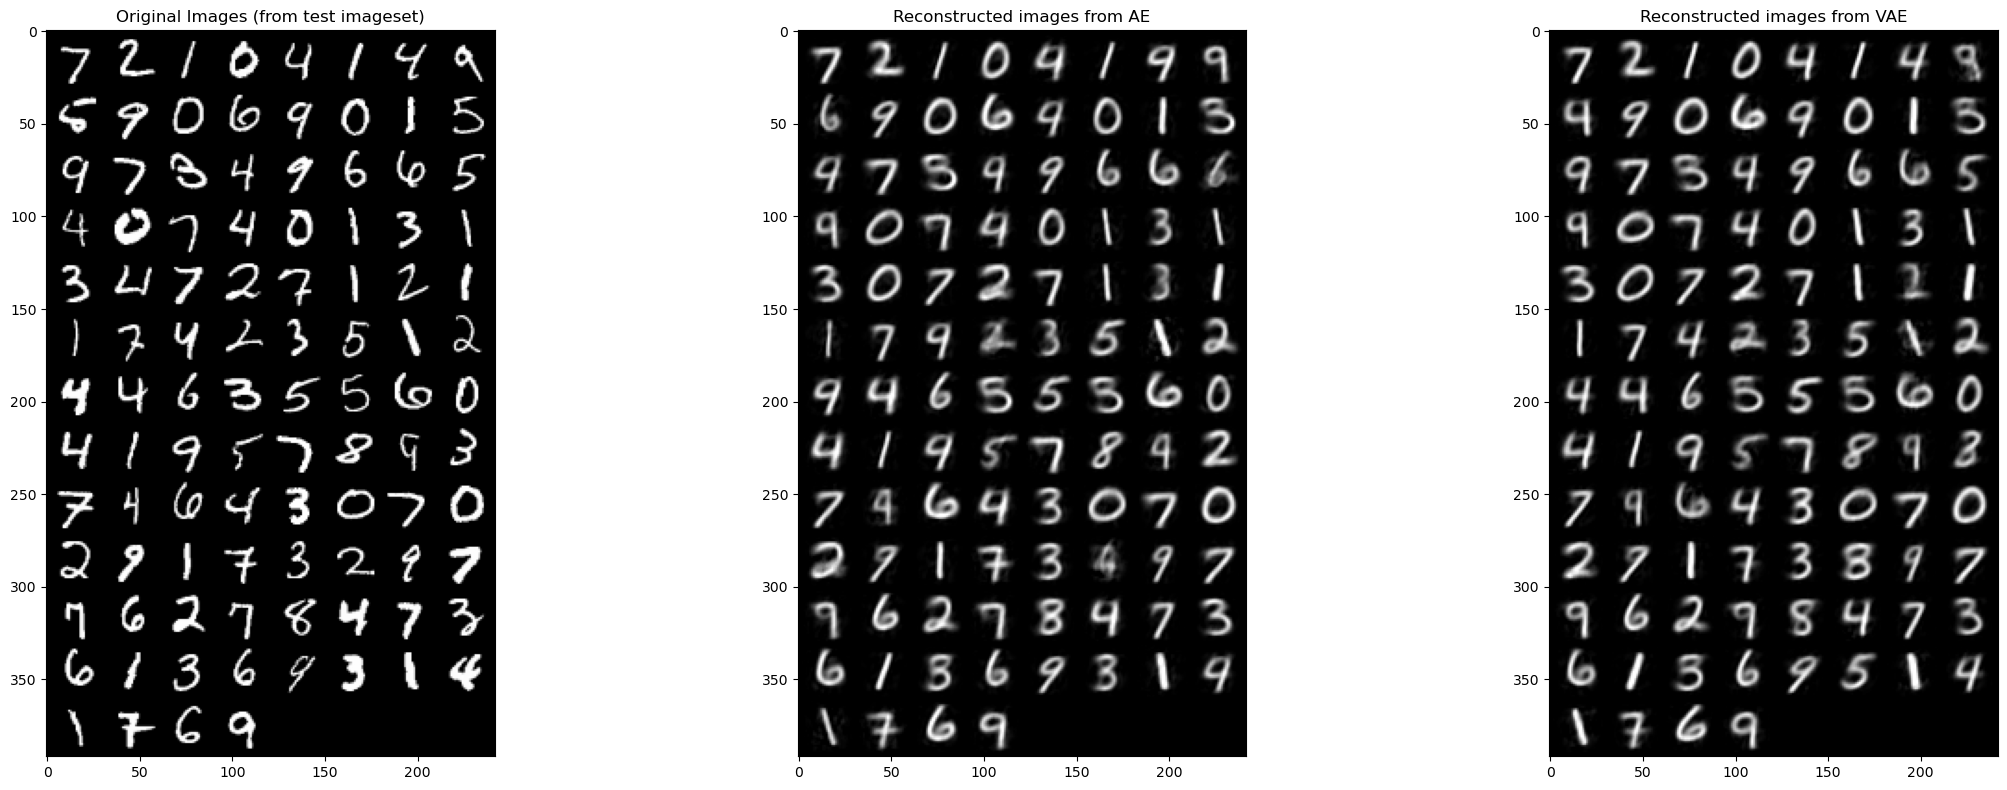

In [185]:
# testing performance of VAE
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs_ae = model_ae(images.reshape((-1,28*28)).to(device))
outputs_vae, _, _ = model_vae(images.reshape((-1,28*28)).to(device))

fig, axs = plt.subplots(1,3,figsize=(24,8))

axs[0].imshow(np.transpose(torchvision.utils.make_grid(images),(1,2,0)))
axs[1].imshow(np.transpose(torchvision.utils.make_grid(outputs_ae.cpu().detach().reshape(images.shape)),(1,2,0)))
axs[2].imshow(np.transpose(torchvision.utils.make_grid(outputs_vae.cpu().detach().reshape(images.shape)),(1,2,0)))
axs[0].set_title('Original Images (from test imageset)')
axs[1].set_title('Reconstructed images from AE')
axs[2].set_title('Reconstructed images from VAE')
plt.tight_layout()
plt.show()

Here, I will compare the latent representations of MNIST training imageset between AE and VAE

In [146]:
# get the latent representations of test imageset
n_data = len(training_data)
batch_size=100

latent_train_ae = torch.zeros((n_data,2))
latent_train_vae = torch.zeros((n_data,2))

labels_train = torch.zeros(n_data)
train_loader = DataLoader(training_data, batch_size=batch_size)

for i, data in enumerate(train_loader, 0):

    # get the inputs
    images, labels = data 
    images = images.reshape((-1, 28*28)).to(device)

    z_ae = model_ae.encode(images)
    z_vae = model_vae.encode_mean(images)    

    latent_train_ae[i*(batch_size):(i+1)*(batch_size),:] = z_ae.cpu().detach()
    latent_train_vae[i*(batch_size):(i+1)*(batch_size),:] = z_vae.cpu().detach()

    labels_train[i*(batch_size):(i+1)*(batch_size)] = labels

Because MNIST dataset is relatively simple, you can see that both AE and VAE has some structured latent space even if they have two-dimensional space.
However, you can see that the latent space of VAE is more organized well because of its constratints (that are coming from KL-div loss).

This will become more clear if you test with more complex dataset or if you construct AE/VAE with more than two dimensional latent space. 
In the latter case, you may need to apply dimensionality reduction technique to visualize the latent space, but make sure the dimensionality reduction technique (e.g., PCA, t-SNE, MDS) may distort some information.

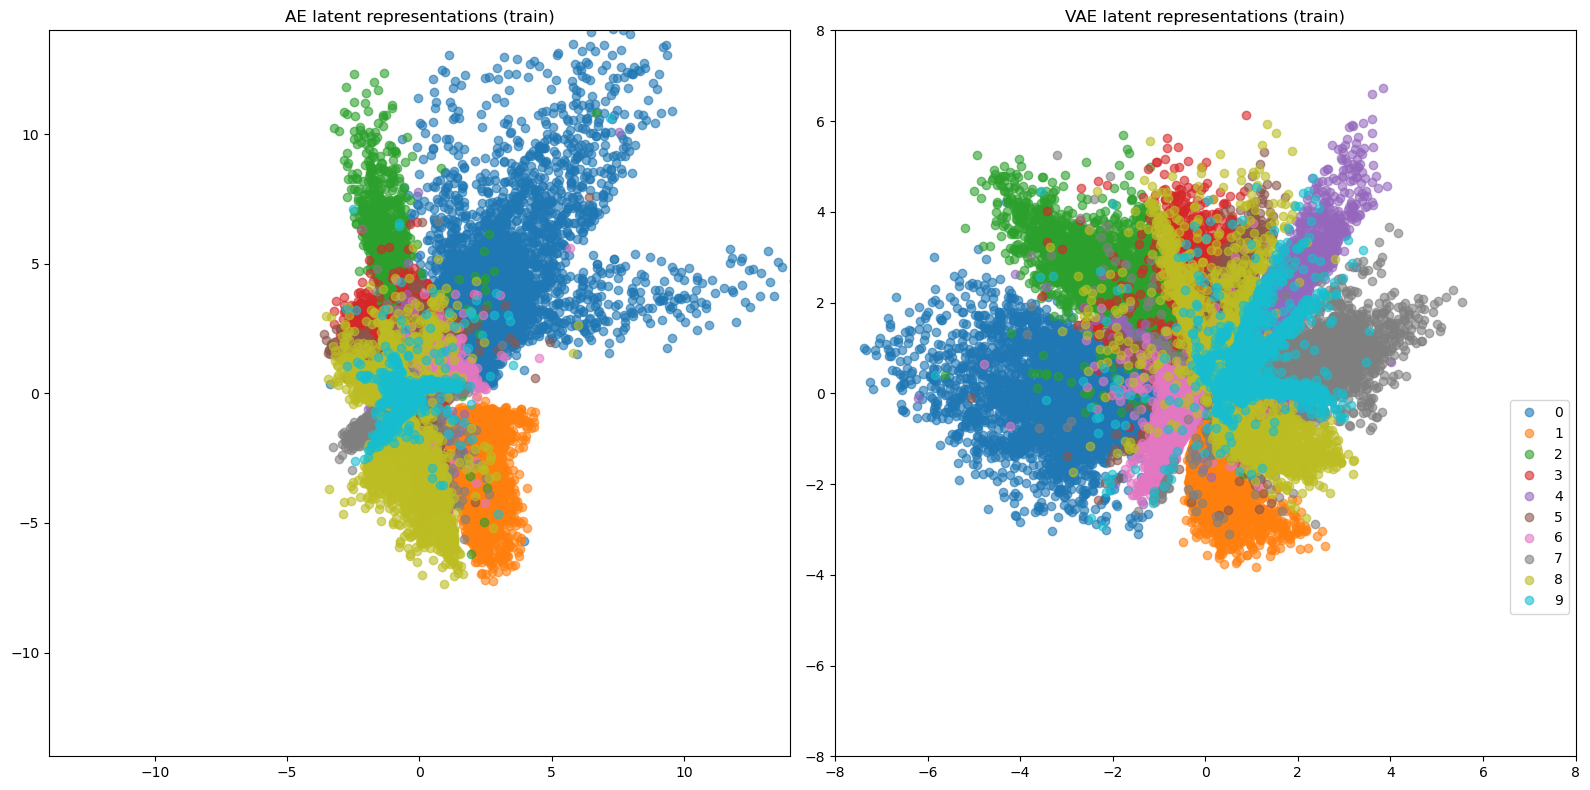

In [148]:
import matplotlib.cm as cm 

fig, axs = plt.subplots(1,2, figsize=(16, 8))

colors = cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    idx = labels_train==i
    
    axs[0].plot(latent_train_ae[idx,0],latent_train_ae[idx,1],'o',color=colors[i], alpha=0.6, label=i)
    axs[1].plot(latent_train_vae[idx,0],latent_train_vae[idx,1],'o',color=colors[i], alpha=0.6, label=i)

axs[0].set(xlim=(-14,14),ylim=(-14,14))
axs[1].set(xlim=(-8,8),ylim=(-8,8))

axs[0].set_title('AE latent representations (train)')
axs[1].set_title('VAE latent representations (train)')
axs[1].legend(bbox_to_anchor=(1,0.5))

plt.tight_layout()
plt.show()

Although now it is more commonly done with GAN or diffusion model, VAE can be used to generate new examples. 
To do this, you need to start from a point in the latent space and feed it to the decoder to get the output.

You may be able to do the same thing with AE, but AE is not commonly used for this job. VAE is more preferred because its latent space tends to have a better structure.
(But AE is also likely to work relatively well in the example given that it also has some meaningful structure in the latent space as shown above)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'new examples generated by VAE')

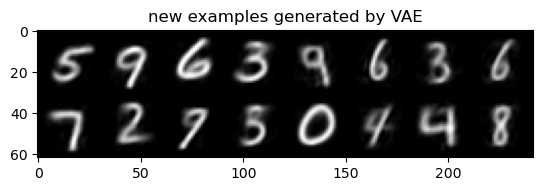

In [184]:
# choose random point 
n_new = 16

z = torch.randn(n_new,2).to(device)

x_new = model_vae.decode(z)
plt.imshow(np.transpose(torchvision.utils.make_grid(x_new.cpu().detach().reshape(n_new,1,28,28)),(1,2,0)))
plt.title('new examples generated by VAE')